# Detecting Switches  
> This module provides tools to identify potential isoform switches within single-cell isoform-resolution datasets. It includes methods based on Dirichlet distributions and Wilcoxon tests for detecting differential isoform usage. These approaches are still under development and intended for exploratory use, with manual confirmation of detected isoform switches being essential.  


In [1]:
#| hide
from nbdev.showdoc import *

In [2]:
#| default_exp switch_search

In [3]:
#| export
import anndata as ad

In [4]:
# | export
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import gammaln
from scipy.optimize import minimize
from itertools import combinations
from scipy.stats import chi2
from statsmodels.stats.multitest import multipletests
import scanpy as sc
import requests
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

###############################################################################
# Helper functions for Dirichlet-Multinomial Negative Log-Likelihood + MLE
###############################################################################
def _dirichlet_multinomial_nll(alpha, data_np):
    """
    Compute the negative log-likelihood for a Dirichlet-Multinomial model,
    given 'data_np' (shape M x K) and 'alpha' (shape K, > 0).
    Omits the factorial terms that don't depend on alpha.
    """
    if np.any(alpha <= 0):
        return np.inf

    alpha_sum = np.sum(alpha)
    nll = 0.0
    for row in data_np:
        N = np.sum(row)
        # part that depends on alpha_sum
        nll -= gammaln(alpha_sum)
        nll += gammaln(alpha_sum + N)
        # part that depends on alpha_j
        for j in range(len(alpha)):
            nll -= gammaln(alpha[j] + row[j]) - gammaln(alpha[j])
    return float(nll)

def _dm_mle(data):
    """
    SciPy-based Dirichlet-Multinomial MLE on a NumPy array.
    data: shape (M, K)
    Returns: (nll, alpha_hat)
    """
    K = data.shape[1]

    def objective(alpha):
        return _dirichlet_multinomial_nll(alpha, data)

    init_alpha = np.ones(K) + 0.1
    bounds = [(1e-9, None)] * K

    result = minimize(
        fun=objective,
        x0=init_alpha,
        method='L-BFGS-B',
        bounds=bounds,
        options={'maxiter': 10000, 'ftol': 1e-5}
    )
    if not result.success:
        return float('nan'), np.zeros(K)

    return float(result.fun), result.x


###############################################################################
# Example placeholder for a scattermap function (if you have your own, remove this)
###############################################################################
def scattermap(color_data, marker_size=None, square=True, cmap="Reds",
               cbar_kws=None, xticklabels=None, yticklabels=None, **kwargs):
    """
    Minimal example of a "scattermap" function that draws circles whose
    color indicates one value and size indicates another. You likely have
    your own version. Adjust as needed, or remove if you define it elsewhere.
    """
    fig, ax = plt.subplots()
    n_rows = color_data.shape[0]
    n_cols = color_data.shape[1]

    if marker_size is None:
        marker_size = np.ones_like(color_data)*20.0

    # Plot each cell as a circle in a grid.
    for i in range(n_rows):
        for j in range(n_cols):
            # x is column index, y is row index
            circle_color = color_data[i, j]
            circle_size = marker_size[i, j]*5  # scale up
            sc = ax.scatter(j, i, s=circle_size, c=circle_color,
                            cmap=cmap, vmin=color_data.min(), vmax=color_data.max())
    # Ticks
    ax.set_xticks(range(n_cols))
    ax.set_yticks(range(n_rows))
    if xticklabels is not None:
        ax.set_xticklabels(xticklabels, rotation=90)
    if yticklabels is not None:
        ax.set_yticklabels(yticklabels)
    if cbar_kws is None:
        cbar_kws = {}
    plt.colorbar(sc, ax=ax, **cbar_kws)
    if square:
        ax.set_aspect('equal', adjustable='box')
    return ax


###############################################################################
# The SwitchSearch class
###############################################################################
import anndata as ad
import scanpy as sc

class SwitchSearch(sc.AnnData):
    """
    An AnnData subclass with specialized Dirichlet-based and Wilcoxon-based
    isoform 'switch' detection methods, plus helper plots and caches.
    """

    def __init__(self, anndata: ad.AnnData):
        warnings.simplefilter(action='ignore', category=FutureWarning)


        self.colors = ["#BF045B", "#038C33", "#73BF86", "#D9B29C", 
                       "#A65F46", "#D9C252", "#F2BF91", "#A69C94", 
                       "#D9763D", "#8C2F1B"]
        self.relevant_genes = None

        # Caches for single-group and combined fits:
        self._single_fit_cache = {}    # (group_label, gene_id) -> (nll, alpha) or None
        self._combined_fit_cache = {}  # (group1_label, group2_label, gene_id) -> (nll, alpha) or None

        # Initialize as an actual AnnData object
        self._init_as_actual(anndata.copy())

        # Optional: if you rely on a 'transcriptId' column later, ensure it exists
        if 'transcriptId' not in self.var_keys():
            self.gene_counts = self.var.reset_index().groupby(by='geneId').count()
            self.var['transcriptId'] = self.var.index


    ###########################################################################
    # Internal: filter raw data to multi-isoform genes
    ###########################################################################
    def __filter_isodata(self):
        """
        Returns a copy of self restricted to genes that have >1 isoform
        (based on 'geneId' in self.var).
        """
        if 'geneId' not in self.var.columns:
            # We can't filter
            return self.copy()

        genes, freq = np.unique(self.var['geneId'], return_counts=True)
        df = pd.DataFrame({"geneId": genes, "frequencies": freq})
        multi_iso_genes = df[df["frequencies"] > 1]['geneId'].tolist()

        adata_iso = self[:, self.var['geneId'].isin(multi_iso_genes)].copy()
        return adata_iso

    ###########################################################################
    # Internal: compute iso percentages
    ###########################################################################
    def iso_percent(self, df, barcodes_regex="^[ACGT]+$"):
        """
        Given a df with each isoform in rows, cell barcodes in columns,
        sum counts per gene, then convert to fraction of total for that gene.
        'barcodes_regex' identifies which columns are actual cells.
        """
        iso_perc_df = df.copy(deep=True)

        # Identify the columns that match 'barcodes_regex'
        # For demonstration, let's just assume every column except geneId/transcriptId is a "barcode".
        if len(iso_perc_df.filter(regex=(barcodes_regex)).columns) < 1:
            raise ValueError("No cell-barcode columns were identified. Check 'barcodes_regex' or your column naming.")

        cols_barcodes = iso_perc_df.filter(regex=(barcodes_regex)).columns
        gene_sums = iso_perc_df.groupby(['geneId'])[cols_barcodes].transform('sum')
        iso_perc_df[cols_barcodes] = iso_perc_df[cols_barcodes] / gene_sums
        iso_perc_df.replace(np.nan, 0.0, inplace=True)

        return iso_perc_df

    ###########################################################################
    # Dirichlet-based single-group / combined fits, with caching
    ###########################################################################
    def __fit_single_group(self, group_label, gene_id, cell_group_column='cell_type'):
        """
        Returns (nll, alpha) for a single group's data on a given gene,
        filtered to rows with sum > 9. Uses and updates self._single_fit_cache.
        If no data remains, returns (np.nan, None).
        """
        cache_key = (group_label, gene_id)
        if cache_key in self._single_fit_cache:
            return self._single_fit_cache[cache_key]

        group_data = self[self.obs[cell_group_column] == group_label]
        if 'geneId' not in group_data.var.columns:     
            return (np.nan, None)

        mask_gene = (group_data.var['geneId'] == gene_id)
        data = group_data[:, mask_gene].X.toarray()
        total_counts = data.sum(axis=1)
        data = data[total_counts > 9]

        if data.shape[0] == 0:
            self._single_fit_cache[cache_key] = (np.nan, None)
            return (np.nan, None)

        nll, alpha = _dm_mle(data)
        self._single_fit_cache[cache_key] = (nll, alpha)
        return (nll, alpha)

    def __fit_combined(self, group_label1, group_label2, gene_id, cell_group_column='cell_type'):
        """
        Returns (nll, alpha) for combined data from group_label1 + group_label2 on a gene,
        filtered to rows with sum > 9. Caches results. If no data remains, returns (np.nan, None).
        """
        cache_key = (group_label1, group_label2, gene_id)
        if cache_key in self._combined_fit_cache:
            return self._combined_fit_cache[cache_key]

        # group1
        group1 = self[self.obs[cell_group_column] == group_label1]
        if 'geneId' not in group1.var.columns:
            self._combined_fit_cache[cache_key] = (np.nan, None)
            return (np.nan, None)

        mask1 = (group1.var['geneId'] == gene_id)
        data1 = group1[:, mask1].X.toarray()
        total_counts1 = data1.sum(axis=1)
        data1 = data1[total_counts1 > 9]

        # group2
        group2 = self[self.obs[cell_group_column] == group_label2]
        if 'geneId' not in group2.var.columns:
            self._combined_fit_cache[cache_key] = (np.nan, None)
            return (np.nan, None)

        mask2 = (group2.var['geneId'] == gene_id)
        data2 = group2[:, mask2].X.toarray()
        total_counts2 = data2.sum(axis=1)
        data2 = data2[total_counts2 > 9]

        # Combined
        if data1.shape[0] == 0 or data2.shape[0] == 0:
            self._combined_fit_cache[cache_key] = (np.nan, None)
            return (np.nan, None)

        combined_data = np.vstack([data1, data2])
        nll, alpha = _dm_mle(combined_data)
        self._combined_fit_cache[cache_key] = (nll, alpha)
        return (nll, alpha)

    def __cached_LRT_test(self, group_label1, group_label2, gene_id, cell_group_column='cell_type'):
        """
        Performs the LRT: 2*(nll_full - (nll1 + nll2)) ~ Chi2(K).
        Uses cached single-group and combined fits. Returns None if something fails.
        Otherwise returns (chi2_stat, p_value, alpha_full, alpha1, alpha2).
        """
        loss1, alpha1 = self.__fit_single_group(group_label1, gene_id, cell_group_column)
        loss2, alpha2 = self.__fit_single_group(group_label2, gene_id, cell_group_column)
        if alpha1 is None or alpha2 is None or np.isnan(loss1) or np.isnan(loss2):
            return None

        loss_full, alpha_full = self.__fit_combined(group_label1, group_label2, gene_id, cell_group_column)
        if alpha_full is None or np.isnan(loss_full):
            return None

        chi2_stat = 2.0 * (loss_full - (loss1 + loss2))
        if chi2_stat < 0:
            return None

        K = len(alpha_full)  # degrees of freedom
        p_value = 1.0 - chi2.cdf(chi2_stat, df=K)
        return chi2_stat, p_value, alpha_full, alpha1, alpha2

    def __compare_groups(self, group_1_label, group_2_label, cell_group_column, gene_id):
        """
        Return a dict with 'chi2_stat', 'p_value', 'alpha_*' for the two groups + combined,
        plus transcript_ids, or None if no test was done.
        """
        test_result = self.__cached_LRT_test(group_1_label, group_2_label, gene_id, cell_group_column)
        if test_result is None:
            return None
        chi2_stat, p_value, alpha_combined, alpha1, alpha2 = test_result

        # gather the transcripts associated with that gene
        transcripts = self.var_names[self.var['geneId'] == gene_id].tolist()
        return {
            "chi2_stat": chi2_stat,
            "p_value": p_value,
            "alpha_combined": alpha_combined.tolist(),
            "alpha1": alpha1.tolist(),
            "alpha2": alpha2.tolist(),
            "transcript_ids": transcripts
        }

    ###########################################################################
    # Updated version of __filter_genes with filter_loud parameter
    ###########################################################################
    def __filter_genes(
        self,
        group_1_label,
        group_2_label,
        cell_group_column,
        min_count=9,
        min_diff=0.1,
        filter_loud=False
    ):
        """
        Restrict to genes present in both groups at min_count, and
        that differ in overall transcript usage by at least min_diff.
        Returns a new SwitchSearch containing the filtered data.

        Parameters
        ----------
        group_1_label : str
            Label/name of group 1.
        group_2_label : str
            Label/name of group 2.
        cell_group_column : str
            Column in self.obs that defines the cell groups/types.
        min_count : int
            Minimum total read threshold (group1 + group2) for a gene to be considered.
        min_diff : float
            Minimum difference in overall transcript usage for the gene to remain.
        filter_loud : bool
            If True, prints debugging info about how many genes pass each filtering step.
        """
        group_1 = self[self.obs[cell_group_column] == group_1_label]
        group_2 = self[self.obs[cell_group_column] == group_2_label]

        gene_counts_1 = np.array(group_1.X.sum(axis=0)).flatten()
        gene_counts_2 = np.array(group_2.X.sum(axis=0)).flatten()
        total_gene_counts = gene_counts_1 + gene_counts_2

        # Genes passing total read threshold
        valid_genes_mask = total_gene_counts > min_count
        if filter_loud:
            n_genes_initial = self.shape[1]
            n_genes_passing_count = np.sum(valid_genes_mask)
            print(f"[filter_genes] Step 1: Genes passing total read threshold (> {min_count}): "
                  f"{n_genes_passing_count} / {n_genes_initial}")

        adata_slice = self[:, valid_genes_mask]

        # Now each group's slice
        group_1_slice = adata_slice[adata_slice.obs[cell_group_column] == group_1_label]
        group_2_slice = adata_slice[adata_slice.obs[cell_group_column] == group_2_label]

        nz1 = (group_1_slice.X != 0).sum(axis=0) > min_count
        nz2 = (group_2_slice.X != 0).sum(axis=0) > min_count
        final_valid_genes = nz1 & nz2

        if filter_loud:
            n_after_nz1 = np.sum(nz1)
            n_after_nz2 = np.sum(nz2)
            n_after_nz_combined = np.sum(final_valid_genes)
            print(f"[filter_genes] Step 2: Genes with > {min_count} nonzero cells in group 1: {n_after_nz1}")
            print(f"[filter_genes]         Genes with > {min_count} nonzero cells in group 2: {n_after_nz2}")
            print(f"[filter_genes]         Intersection passing: {n_after_nz_combined}")

        filtered_data = adata_slice[:, final_valid_genes]

        # Additional pass: exclude genes whose transcripts do not differ by > min_diff
        unique_gene_ids = np.unique(filtered_data.var['geneId'])
        to_remove = []
        for gene_id in unique_gene_ids:
            sub1 = filtered_data[
                (filtered_data.obs[cell_group_column] == group_1_label),
                (filtered_data.var['geneId'] == gene_id)
            ]
            sub2 = filtered_data[
                (filtered_data.obs[cell_group_column] == group_2_label),
                (filtered_data.var['geneId'] == gene_id)
            ]
            X1 = sub1.X.astype(float).toarray()
            X2 = sub2.X.astype(float).toarray()
            if X1.sum() == 0 or X2.sum() == 0:
                to_remove.append(gene_id)
                continue
            percent_1 = X1 / X1.sum()
            percent_2 = X2 / X2.sum()
            diff_found = False
            for col_idx in range(percent_1.shape[1]):
                if abs(percent_1[:, col_idx].sum() - percent_2[:, col_idx].sum()) > min_diff:
                    diff_found = True
                    break
            if not diff_found:
                to_remove.append(gene_id)

        # Remove those genes in 'to_remove'
        before_remove_count = filtered_data.shape[1]
        filtered_data = filtered_data[:, ~filtered_data.var['geneId'].isin(to_remove)]
        after_remove_count = filtered_data.shape[1]

        if filter_loud:
            print(f"[filter_genes] Step 3: Genes failing min_diff={min_diff} threshold: {len(to_remove)}")
            print(f"[filter_genes]         Genes before removal: {before_remove_count}, "
                  f"after removal: {after_remove_count}")

        return SwitchSearch(filtered_data)

    ###########################################################################
    # Wilcoxon-based approach using Scanpy
    ###########################################################################
    def __scanpy_wilcoxon_switching_isoforms(self, cell_labels_column='cell_type',
                                             min_fdr=0.05, min_log_fold_change=0.3):
        """
        Mimics the 'get_isoswitches' function you provided, but uses 'self' as the AnnData object.
        Returns a DataFrame of switching isoforms based on Scanpy's rank_genes_groups (Wilcoxon).
        """
        import scanpy as sc

        # We'll work on a copy to avoid mutating 'self'
        adata = self.copy()

        # If the anndata is empty, return empty DataFrame
        if adata.shape[0] == 0:
            return pd.DataFrame()

        # By default, ensure transcriptId is in var
        if 'transcriptId' not in adata.var.columns:
            adata.var['transcriptId'] = adata.var_names

        # Make sure the label column is categorical
        adata.obs[cell_labels_column] = adata.obs[cell_labels_column].astype('category')
        groups = adata.obs[cell_labels_column].cat.categories

        if len(groups) < 2:
            return pd.DataFrame()

        from itertools import combinations
        group_contrasts = list(combinations(groups, 2))
        marker_results_list = {}

        # Perform Wilcoxon-based tests for each pair in both directions
        for group_1, group_2 in group_contrasts:
            try:
                sc.tl.rank_genes_groups(
                    adata, groupby=cell_labels_column, groups=[group_1],
                    reference=group_2, method='wilcoxon', n_genes=adata.shape[0]
                )
                df1 = sc.get.rank_genes_groups_df(adata, group=group_1)
                df1['group_1'] = group_1
                df1['group_2'] = group_2
                df1['contrast'] = f"{group_1}__{group_2}"

                sc.tl.rank_genes_groups(
                    adata, groupby=cell_labels_column, groups=[group_2],
                    reference=group_1, method='wilcoxon', n_genes=adata.shape[0]
                )
                df2 = sc.get.rank_genes_groups_df(adata, group=group_2)
                df2['group_1'] = group_2
                df2['group_2'] = group_1
                df2['contrast'] = f"{group_1}__{group_2}"

                if not df1.empty and not df2.empty:
                    marker_results_list[df1['contrast'].iloc[0]] = pd.concat([df1, df2], ignore_index=True)

            except ValueError:
                pass  # skip if it fails

        if not marker_results_list:
            return pd.DataFrame()

        marker_df = pd.concat(marker_results_list.values(), ignore_index=True)

        # If 'transcriptId' isn't in var, try resetting index
        if 'transcriptId' not in adata.var.columns:
            adata.var.reset_index(inplace=True)

        # Map transcripts to genes
        transcript_to_gene = adata.var.set_index('transcriptId')['geneId'].to_dict()
        marker_df['geneId'] = marker_df['names'].map(transcript_to_gene)

        # Add cell counts
        cell_counts = adata.obs[cell_labels_column].value_counts()
        marker_df['n_cells_group_1'] = marker_df['group_1'].map(cell_counts)
        marker_df['n_cells_group_2'] = marker_df['group_2'].map(cell_counts)
        marker_df['total_cells'] = marker_df['n_cells_group_1'] + marker_df['n_cells_group_2']

        # Adjust p-values and filter
        marker_df['adj_pval'] = multipletests(marker_df['pvals_adj'], method='fdr_bh')[1]
        marker_df_filtered = marker_df[
            (marker_df['adj_pval'] <= min_fdr) &
            (marker_df['logfoldchanges'].abs() >= min_log_fold_change)
        ]

        def assign_direction(df):
            return df.assign(
                direction=np.where(
                    df['group_1'] == df['contrast'].str.split("__").str[0],
                    df['logfoldchanges'],
                    -df['logfoldchanges']
                )
            )

        isoswitch_df = (
            marker_df_filtered
            .groupby(['geneId', 'contrast'])
            .apply(assign_direction)
            .reset_index(drop=True)
            .groupby(['geneId', 'contrast'])
            .filter(lambda x: (
                len(x['group_1'].unique()) > 1 and
                len(x['names'].unique()) > 1 and
                x['direction'].abs().sum() != 0
            ))
        )

        def calculate_percent_expression(adata, groupby_column, group, transcript):
            subset = adata[adata.obs[groupby_column] == group, transcript]
            return (subset.X > 0).mean() * 100

        percent_expressions = isoswitch_df.apply(
            lambda row: pd.Series({
                'percent_expressed_group_1': calculate_percent_expression(adata, cell_labels_column, row['group_1'], row['names']),
                'percent_expressed_group_2': calculate_percent_expression(adata, cell_labels_column, row['group_2'], row['names'])
            }),
            axis=1
        )
        isoswitch_df = pd.concat([isoswitch_df, percent_expressions], axis=1)
        isoswitch_df.sort_values(by='adj_pval', inplace=True)

        return isoswitch_df

    ###########################################################################
    # Public method: find_switching_isoforms
    ###########################################################################
    def find_switching_isoforms(
        self,
        cell_group_column='cell_type',
        min_count=30,
        min_diff=0.2,
        method="ScanpyWilcoxon",
        min_fdr=0.05,
        min_log_fold_change=0.5,
        filter_loud=False
    ):
        """
        Finds switching isoforms. By default uses a Wilcoxon-based approach
        (Scanpy's rank_genes_groups). If you want the original Dirichlet-based
        approach, specify `method='Dirichlet'`.

        For Dirichlet:
            - min_count, min_diff apply
            - filter_loud: if True, prints debug info during filtering
        For Wilcoxon:
            - min_fdr, min_log_fold_change apply
            - filter_loud is ignored

        Returns a DataFrame of results (for Wilcoxon) or sets self.relevant_genes (for Dirichlet).
        """
        if method == "Dirichlet":
            if 'geneId' not in self.var.columns:
                return pd.DataFrame()

            cell_types = self.obs[cell_group_column].unique()
            gene_ids = self.var['geneId'].unique()

            results = []
            from itertools import combinations
            for (g1, g2) in combinations(cell_types, 2):
                # filter the data for these two groups, with optional debugging
                filtered_adata = self.__filter_genes(
                    g1, g2,
                    cell_group_column=cell_group_column,
                    min_count=min_count,
                    min_diff=min_diff,
                    filter_loud=filter_loud
                )
                # run a test on every gene in gene_ids
                for gene_id in gene_ids:
                    if gene_id not in filtered_adata.var['geneId'].values:
                        continue
                    item = filtered_adata.__compare_groups(g1, g2, cell_group_column, gene_id)
                    if item is not None:
                        results.append({
                            'gene_id': gene_id,
                            'group_1': g1,
                            'group_2': g2,
                            'p_value': item['p_value'],
                            'chi2_stat': item['chi2_stat'],
                            'alpha_combined': item['alpha_combined'],
                            'alpha1': item['alpha1'],
                            'alpha2': item['alpha2'],
                            'transcript_ids': item['transcript_ids']
                        })

            results_df = pd.DataFrame(results)
            self.relevant_genes = results_df
            return results_df

        else:
            # New approach: Wilcoxon with Scanpy
            isoswitch_df = self.__scanpy_wilcoxon_switching_isoforms(
                cell_labels_column=cell_group_column,
                min_fdr=min_fdr,
                min_log_fold_change=min_log_fold_change
            )
            return isoswitch_df

    ###########################################################################
    # Major/Minor isoforms: simple method that looks at average usage
    ###########################################################################
    def __find_major_minor_isoforms(self):
        """
        Example method returning the transcript IDs that are 'major' in
        exactly one cell type. Adjust to your logic as needed.
        """
        df = self.__filtered_anndata.to_df()
        df['cell_type'] = self.__filtered_anndata.obs['cell_type']
        df = df.groupby('cell_type').mean().transpose()
        df['geneId'] = self.__filtered_anndata.var['geneId']
        df['is_major'] = ''

        for ct in self.__filtered_anndata.obs['cell_type'].unique():
            # For each gene, pick transcript(s) with max usage in that group
            df.loc[df[ct] == df.groupby('geneId')[ct].transform('max'), 'is_major'] += ct + ','

        di = df['is_major'].to_dict()
        d = {}
        for (k, v) in di.items():
            d[k] = len(v.split(',')) - 1  # how many cell types was this transcript "major"?

        # example logic: transcripts that are major in exactly 1 cell type
        tr_ids = list(set(k for (k, v) in d.items() if v == 1))
        return tr_ids

    def find_major_minor_isoforms(self):
        return self.__find_major_minor_isoforms()

    ###########################################################################
    # Plot a matrix of transcripts by cell type, using "scattermap"
    ###########################################################################
    def plot_relevant_genes(self, gene_id, p_value_threshold=0.05, data=None):
        """
        For Dirichlet-based results (self.relevant_genes), generate a matrix
        of transcripts vs. cell_types that had a p-value < threshold,
        with circle color representing #nonzero usage, circle size representing sum of counts.
        """
        if data is not None:
            self.relevant_genes = data
        if not hasattr(self, 'relevant_genes') or self.relevant_genes is None:
            raise ValueError(
                "Please run `find_switching_isoforms(method='Dirichlet')` first to fill `self.relevant_genes`."
            )

        # Subset to this gene & p < threshold
        subset = self.relevant_genes[
            (self.relevant_genes['gene_id'] == gene_id) &
            (self.relevant_genes['p_value'] < p_value_threshold)
        ]
        if subset.empty:
            print("No results found for gene_id =", gene_id)
            return

        # Collect cell types that appear in group_1 or group_2
        ct_pairs = subset[['group_1', 'group_2']].values.tolist()
        cell_types_compare = list({x for pair in ct_pairs for x in pair})

        # Flatten all transcript IDs
        tr_ids = subset['transcript_ids'].tolist()  # list of lists
        tr_ids_flat = list({x for sublist in tr_ids for x in sublist})

        # Prepare data
        tmp = self.to_df().copy()
        tmp['cell_type'] = self.obs['cell_type']
        # sum across transcripts, grouping by cell_type
        genes_sum = tmp[tmp['cell_type'].isin(cell_types_compare)][tr_ids_flat + ['cell_type']].groupby('cell_type').sum()
        # #nonzero usage across transcripts
        genes_nonzero = tmp[tmp['cell_type'].isin(cell_types_compare)].groupby('cell_type').apply(
            lambda x: (x[tr_ids_flat] != 0).sum()
        )

        color_data = genes_nonzero[tr_ids_flat].to_numpy()
        size_data = genes_sum[tr_ids_flat].to_numpy()
        x_labels = tr_ids_flat

        fig = plt.figure()
        ax = scattermap(
            color_data, marker_size=size_data, square=True, cmap="Reds",
            cbar_kws={"label": "Non-zeros"},
            xticklabels=x_labels, yticklabels=cell_types_compare
        )
        mk_size = 60
        # For the legend, we'll show max, mean, min usage as example
        ax.scatter(-1, -1, label=f"{np.amax(size_data):0.1f}", marker="o", c="r", s=mk_size)
        ax.scatter(-1, -1, label=f"{np.mean(size_data):0.1f}", marker="o", c="r", s=mk_size*0.5)
        if np.any(size_data > 0):
            nz_min = np.amin(size_data[np.nonzero(size_data)])
        else:
            nz_min = 0.0
        ax.scatter(-1, -1, label=f"{nz_min:0.1f}", marker="o", c="r", s=mk_size*0.1)
        ax.legend(loc="upper left", bbox_to_anchor=(1.27, -0.05))
        fig.tight_layout()
        plt.show()

    ###########################################################################
    # Simple summary plots of isoforms
    ###########################################################################
    def _plot_genes_cell_type(self, _ax):
        # Summation of counts across transcripts, by cell type
        df = pd.DataFrame(np.transpose(self.X), columns=self.obs['cell_type'])
        df = df.sum(axis=0).to_frame().reset_index()
        df.columns = ['cell_type', 'n_of_genes']

        if _ax is None:
            fig, ax = plt.subplots()
            pal = [self.colors[i % len(self.colors)] for i in range(len(df['cell_type'].unique()))]
            sns.boxplot(x='cell_type', y='n_of_genes', data=df, ax=ax, palette=pal)
            sns.stripplot(x='cell_type', y='n_of_genes', data=df, color='black', size=1, ax=ax)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
            plt.show()
        else:
            pal = [self.colors[i % len(self.colors)] for i in range(len(df['cell_type'].unique()))]
            sns.boxplot(x='cell_type', y='n_of_genes', data=df, ax=_ax, palette=pal)
            sns.stripplot(x='cell_type', y='n_of_genes', data=df, color='black', size=1, ax=_ax)
            _ax.set_xticklabels(_ax.get_xticklabels(), rotation=90)

    def plot_genes_cell_type(self):
        self._plot_genes_cell_type(None)

    def _plot_isoforms_frequencies(self, _ax):
        """
        Plots how many genes have exactly k isoforms, for k=1,2,3,...
        """
        iso_per_gene = self.gene_counts
        freq_counts = iso_per_gene['transcriptId'].value_counts()

        if _ax is None:
            fig, ax = plt.subplots()
            freq_counts.plot(ax=ax, kind='bar',
                             xlabel='Number of isoforms per gene',
                             ylabel='Count of genes',
                             color=self.colors[0])
            plt.show()
        else:
            freq_counts.plot(ax=_ax, kind='bar',
                             xlabel='Number of isoforms per gene',
                             ylabel='Count of genes',
                             color=self.colors[0])

    def plot_isoforms_frequencies(self):
        self._plot_isoforms_frequencies(None)

    def _plot_switch_gen_bar(self, _ax):
        """
        Shows fraction of genes that have multiple isoforms vs. single isoform,
        plus total transcripts in an adjacent bar.
        """
        iso_per_gene = self.gene_counts
        multiple_iso = sum(iso_per_gene['transcriptId'] > 1)
        mono_iso = sum(iso_per_gene['transcriptId'] <= 1)

        lab_multi = f"{100.0*multiple_iso/(multiple_iso+mono_iso):.1f}%"
        lab_mono = f"{100.0*mono_iso/(multiple_iso+mono_iso):.1f}%"

        x = ['genes']
        x_tr = ['transcripts']

        if _ax is None:
            fig, ax = plt.subplots()
            ax.bar(x, multiple_iso, color=self.colors[0])
            ax.bar(x, mono_iso, bottom=multiple_iso, color=self.colors[1])
            ax.text(0, multiple_iso/2, lab_multi, ha="center", va="center", color="white")
            ax.text(0, multiple_iso + mono_iso/2, lab_mono, ha="center", va="center", color="white")
            ax.bar(x_tr, len(self.var['transcriptId']), color=self.colors[2])
            plt.show()
        else:
            _ax.bar(x, multiple_iso, color=self.colors[0])
            _ax.bar(x, mono_iso, bottom=multiple_iso, color=self.colors[1])
            _ax.text(0, multiple_iso/2, lab_multi, ha="center", va="center", color="white")
            _ax.text(0, multiple_iso + mono_iso/2, lab_mono, ha="center", va="center", color="white")
            _ax.bar(x_tr, len(self.var['transcriptId']), color=self.colors[2])

    def plot_switch_gen_bar(self):
        self._plot_switch_gen_bar(None)

    def plot_isoforms_summary(self):
        """
        Simple summary combining multiple subplots in one figure.
        """
        fig = plt.figure(figsize=(14, 4))

        ax1 = fig.add_subplot(131)
        self._plot_switch_gen_bar(ax1)
        ax1.set_title("Multiple isoforms genes %")

        ax2 = fig.add_subplot(132)
        self._plot_isoforms_frequencies(ax2)
        ax2.set_title("Frequency of isoforms per gene")

        ax3 = fig.add_subplot(133)
        self._plot_genes_cell_type(ax3)
        ax3.set_title("Nb of genes per cell type")

        plt.tight_layout()
        plt.show()

    ############################################################################
    # Utility: look up transcript common names (e.g., from Ensembl) if needed
    ############################################################################
    def get_transcripts_common_names(self, transcript_ids):
        """
        Calls Ensembl's REST API to get display_name for each transcript in transcript_ids.
        If a transcript has a version (e.g., .N), we strip that before calling.
        """
        tr_common_names = []
        server = "https://rest.ensembl.org"

        for tid in transcript_ids:
            tid_stripped = tid.split('.')[0] if '.' in tid else tid
            ext = f"/lookup/id/{tid_stripped}?expand=1"
            r = requests.get(server + ext, headers={"Content-Type": "application/json"})
            if not r.ok:
                tr_common_names.append(tid)
                continue
            decoded = r.json()
            tr_common_names.append(decoded.get('display_name', tid))

        return tr_common_names

    ############################################################################
    # Transcript structure drawing (simple Ensembl exons)
    ############################################################################
    def __get_coord_from_tscrpt_id(self, transcript_id):
        """
        Query Ensembl for the exon coordinates for the given transcript.
        Return (list_of_exons, strand).
        Each element in list_of_exons is a tuple (start, end).
        """
        tid_stripped = transcript_id.split('.')[0] if '.' in transcript_id else transcript_id
        server = "https://rest.ensembl.org"
        ext = f"/lookup/id/{tid_stripped}?expand=1"
        r = requests.get(server+ext, headers={"Content-Type": "application/json"})
        if not r.ok:
            r.raise_for_status()

        decoded = r.json()
        exon_list = decoded.get('Exon', [])
        exons = []
        for e in exon_list:
            exons.append((e['start'], e['end']))
        strand = decoded.get('strand', 1)
        return exons, strand

    def __draw_exons(self, exons, strand, color, transcript_name,
                     offset=0, start_override=None, end_override=None, no_render=False):
        """
        Draw a schematic of exons for a single transcript.
        If 'strand' == 1, arrow goes left->right, else reversed.
        If 'start_override'/'end_override' are set, we use them to scale everything.
        """
        if not no_render:
            plt.axes()
            plt.xlim((-0.1, 1))
            plt.ylim((-0.3, 0.3))
            plt.margins(0.2)
            plt.axis('off')
            fig = plt.gcf()
            fig.set_size_inches(20, 2)

        height = 0.2
        if strand == 1:
            exons_sorted = sorted(exons, key=lambda x: x[0])  # sort by start
            real_start, real_end = exons_sorted[0][0], exons_sorted[-1][1]
        else:
            exons_sorted = sorted(exons, key=lambda x: x[0], reverse=True)
            real_start, real_end = exons_sorted[-1][0], exons_sorted[0][1]

        if start_override is not None and end_override is not None:
            pos_start = start_override
            pos_end = end_override
        else:
            pos_start, pos_end = real_start, real_end

        total_length = pos_end - pos_start
        total_length_with_margin = 1.05 * total_length
        pos_start_margin = pos_start - 0.025 * total_length

        # draw the exon rectangles
        for (s, e) in exons_sorted:
            left = (s - pos_start_margin) / total_length_with_margin
            w = (e - s) / total_length_with_margin
            rect = plt.Rectangle((left, offset), w, height, fc=color, ec="black")
            plt.gca().add_patch(rect)

        # draw an arrow line
        if len(exons) > 1:
            if strand < 0:
                # arrow from right to left
                arrow = plt.arrow(1, offset - height/4, -1, 0,
                                  width=0.0015, head_length=0.01, head_width=0.1,
                                  length_includes_head=True, overhang=1)
            else:
                # arrow from left to right
                arrow = plt.arrow(0, offset - height/4, 1, 0,
                                  width=0.0015, head_length=0.01, head_width=0.1,
                                  length_includes_head=True, overhang=1)
            plt.gca().add_patch(arrow)

        # draw start & end tick marks
        x_start = (real_start - pos_start_margin) / total_length_with_margin
        x_end = (real_end - pos_start_margin) / total_length_with_margin

        plt.plot([x_start, x_start],
                 [offset - height/4 - 0.03, offset - height/4 + 0.03],
                 color='black')
        plt.plot([x_end, x_end],
                 [offset - height/4 - 0.03, offset - height/4 + 0.03],
                 color='black')

        plt.text(x_start, offset - height/4 - 0.075,
                 str(real_start), ha='center', va='center', fontsize=9)
        plt.text(x_end, offset - height/4 - 0.075,
                 str(real_end), ha='center', va='center', fontsize=9)

        plt.text(1, offset - height,
                 transcript_name, ha='right', va='top', fontsize=12)

        if not no_render:
            plt.show()

    def __get_transcripts_from_gene(self, gene_name):
        """
        Return the transcriptIds in self.var that match the given geneId.
        """
        if 'geneId' not in self.var.columns:
            return []
        mask = (self.var['geneId'] == gene_name)
        return self.var.loc[mask, 'transcriptId'].tolist()

    def __draw_transcripts_list(self, gene_name, trs_to_show, _ax, colors=None):
        """
        Draw multiple transcripts for a single gene, stacked.
        Each transcript's exons are displayed horizontally.
        """
        if trs_to_show == []:
            transcripts_id = self.__get_transcripts_from_gene(gene_name)
        else:
            transcripts_id = trs_to_show

        exons_list = []
        strands = []
        for tid in transcripts_id:
            exons, strand = self.__get_coord_from_tscrpt_id(tid)
            exons_list.append(exons)
            strands.append(strand)

        # pick colors
        if colors is None:
            pal = ['#898D90', '#8D93A1', '#9F99B5', '#AFACC9',
                   '#D7CADE', '#DAEDF3', '#F7EABD']
            colors = [pal[i % len(pal)] for i in range(len(exons_list))]

        # get overall min start and max end for scaling
        def get_limits(e_list, s_list):
            start_lim = sys.maxsize
            end_lim = -sys.maxsize
            for e, s in zip(e_list, s_list):
                s0, e0 = sorted(e, key=lambda x: x[0])[0][0], sorted(e, key=lambda x: x[0])[-1][1]
                start_lim = min(start_lim, s0)
                end_lim = max(end_lim, e0)
            return (start_lim, end_lim)

        if len(exons_list) == 0:
            print(f"No transcripts found for gene: {gene_name}")
            return

        (start_global, end_global) = get_limits(exons_list, strands)

        # set up the final figure space
        plt.axes()
        plt.xlim((-0.1, 1.1))
        plt.ylim((0.1 - 0.5*len(exons_list), 0.3))
        plt.margins(0.2)
        plt.axis('off')
        fig = plt.gcf()
        fig.set_size_inches(20, len(exons_list)*2)

        # stack them
        for i, (ex, st, col, tname) in enumerate(zip(exons_list, strands, colors, transcripts_id)):
            offset = -0.5*i
            self.__draw_exons(
                ex, st, col, tname, offset=offset,
                start_override=start_global, end_override=end_global,
                no_render=True
            )

        if _ax is None:
            plt.show()
        else:
            return plt

    def draw_transcripts_list(self, gene_name, colors=None):
        """
        Draw all transcripts for a gene, each stacked horizontally with exons.
        """
        self.__draw_transcripts_list(gene_name, [], None, colors)

    ###########################################################################
    # Quick expression box/violin plot per transcript
    ###########################################################################
    def _trsct_counts_cell_type(self, gene_name, trs_to_show, _ax):
        """
        For a given gene, gather counts across transcripts for each cell_type, then plot.
        """
        df = self.__filtered_anndata.to_df().set_index(self.__filtered_anndata.obs['cell_type'])
        df = df.transpose()
        df[['transcriptId', 'geneId']] = self.__filtered_anndata.var[['transcriptId', 'geneId']]

        gene_iso_count = df[df['geneId'] == gene_name].drop('geneId', axis=1).set_index('transcriptId').transpose()
        melted = gene_iso_count.reset_index().melt(
            id_vars='cell_type', var_name='transcriptId', value_name='count'
        )

        if trs_to_show:
            melted = melted[melted['transcriptId'].isin(trs_to_show)]

        if _ax is None:
            g = sns.catplot(
                x="cell_type", y="count", col="transcriptId",
                aspect=1, dodge=False, kind="violin", data=melted
            )
            g.set_titles(col_template="{col_name}", size=8)
            g.set_xticklabels(rotation=90)
            g.fig.suptitle(gene_name)
            plt.show()
        else:
            g = sns.catplot(
                x="cell_type", y="count", col="transcriptId",
                aspect=1, dodge=False, kind="violin", data=melted
            )
            g.set_titles(col_template="{col_name}", size=8)
            g.set_xticklabels(rotation=90)
            g.fig.suptitle(gene_name)
            return g

    def trsct_counts_cell_type(self, gene_name, trs_to_show=[]):
        self._trsct_counts_cell_type(gene_name, trs_to_show, None)

    def plot_switching_isoforms_boxplot(self, gene_name, trs_to_show=[]):
        """
        Another example that draws boxen plots per transcript across cell_type.
        """
        fig = plt.figure()
        subset = self[:, self.var["geneId"] == gene_name].to_df()
        subset['cell_type'] = self.obs['cell_type']

        if trs_to_show:
            subset = subset[trs_to_show + ['cell_type']]

        data = pd.melt(subset, id_vars=['cell_type'],
                       var_name='transcriptId', value_name='count')
        ax = fig.add_subplot()
        g = sns.catplot(
            ax=ax, x="cell_type", y="count", col="transcriptId",
            aspect=0.5, dodge=False, kind="boxen", data=data,
            flier_kws=dict(marker='.', linewidth=0.5),
            palette=self.colors
        )
        g.fig.set_size_inches(15, 8)
        g.set_xticklabels(rotation=90)

    def draw_gene_summary(self, gene_name, trs_to_show=[]):
        """
        Example that composes multiple subplots: a violin plot by cell_type,
        a stacked bar usage plot, and the transcripts structure diagram.
        """
        fig = plt.figure(figsize=(12, 12))

        # 1. Transcript counts (violin)
        ax1 = fig.add_subplot(311)
        df = self.__filtered_anndata.to_df().set_index(self.__filtered_anndata.obs['cell_type'])
        df = df.transpose()
        df[['transcriptId', 'geneId']] = self.__filtered_anndata.var[['transcriptId', 'geneId']]
        gene_iso_count = df[df['geneId'] == gene_name].drop('geneId', axis=1).set_index('transcriptId').transpose()
        melted = gene_iso_count.reset_index().melt(
            id_vars='cell_type', var_name='transcriptId', value_name='count'
        )
        if trs_to_show:
            melted = melted[melted['transcriptId'].isin(trs_to_show)]
        sns.violinplot(x="cell_type", y="count", hue="transcriptId",
                       data=melted, ax=ax1, split=True)
        ax1.set_title(f"{gene_name} transcript counts by cell type", fontsize=10)
        ax1.legend(bbox_to_anchor=(1.01, 1), loc=2)
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

        # 2. Bar plot of transcript usage
        ax2 = fig.add_subplot(312)
        grouped = self.__filtered_anndata.obsm['Iso_prct'].copy()
        grouped['cell_type'] = self.__filtered_anndata.obs['cell_type']
        res = grouped.groupby('cell_type').mean().transpose()
        res = res.assign(transcriptId=self.__filtered_anndata.var['transcriptId'].to_list())
        res = res.assign(geneId=self.__filtered_anndata.var['geneId'].to_list())
        subres = res[res['geneId'] == gene_name].drop(['geneId'], axis=1)
        if trs_to_show:
            subres = subres[subres['transcriptId'].isin(trs_to_show)]
        plot_data = subres.set_index('transcriptId').transpose()
        plot_data.plot(kind='barh', stacked=True, ax=ax2)
        ax2.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
        ax2.set_title(f"{gene_name} stacked usage by cell type", fontsize=10)

        # 3. Exon structure (transcript diagram)
        ax3 = fig.add_subplot(313)
        self.__draw_transcripts_list(gene_name, trs_to_show, ax3)

        plt.tight_layout()
        plt.show()


In [5]:
# | export
def create_iso_adata(
    path: str  # Path to a tab-separated file, typically the Sicelore output with transcript counts.
):
    """
    Creates an AnnData object containing isoform counts from a Sicelore output file.

    Parameters:
    - path (str): Path to the input file, which is expected to be tab-separated and contain:
        - `transcriptId`: Transcript identifiers.
        - `geneId`: Gene identifiers.
        - Transcript counts for individual barcodes (cells) as additional columns.

    Returns:
    - adata_iso (AnnData): An AnnData object with isoform counts.
    """

    # Open the input file and read it into a Pandas DataFrame
    with open(path) as isoforms:
        df = pd.read_table(isoforms, sep='\t')

    # Extract the count matrix
    # - `df.iloc[0:, 2:]`: assuming these are counts.
    counts = df.iloc[0:, 2:]

    # Create an AnnData object with the count matrix

    adata_iso = ad.AnnData(counts).transpose()

    # Assign transcript IDs as variable names (columns in the original file)
    adata_iso.var_names = df['transcriptId'].to_list()

    # Add additional variable-level metadata
    # - Include both `transcriptId` and `geneId` as annotations for the variables.
    adata_iso.var = df[['transcriptId', 'geneId']]

    # Create observation-level metadata for barcodes (cells)
    # - Extract column names (barcodes) starting from the 3rd column (index 2).
    barcodes = {'barcodes': df.columns.values[2:]}
    barcodes = pd.DataFrame(data=barcodes)

    # Assign the barcodes DataFrame to the AnnData object as observation metadata
    adata_iso.obs = barcodes

    # Set observation names (row indices) in the AnnData object to match the barcodes
    adata_iso.obs_names = barcodes['barcodes'].tolist()

    # Return the AnnData object containing isoform counts
    return adata_iso

In [6]:
from allos.readers_tests import *
combined_mouse_data = process_mouse_data()


🔎 Looking for file at: /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/e18.mouse.clusters.csv
✅ File found at: /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/e18.mouse.clusters.csv
✅ File already exists at: /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/data/mouse_1.txt.gz

🔄 Decompressing /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/data/mouse_1.txt.gz to /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/data/mouse_1.txt...
✅ Decompression complete.
Test data (mouse_1) downloaded successfully
✅ File already exists at: /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/data/mouse_2.txt.gz

🔄 Decompressing /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/data/mouse_2.txt.gz to 

/data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [7]:
Isoform_anndata = SwitchSearch(combined_mouse_data)

In [8]:
switches_Dirichlet = Isoform_anndata.find_switching_isoforms(method = "Dirichlet")

In [9]:
switches_Dirichlet.head(10)

,gene_id,group_1,group_2,p_value,chi2_stat,alpha_combined,alpha1,alpha2,transcript_ids
0,Clta,mature Glutamatergic,intermediate progenitor,9.750177e-08,32.286791,"[0.9617068964257841, 2.0612036714193507]","[693.9698023316483, 2931.093984634617]","[0.8497182587709623, 0.13798793366881604]","[ENSMUST00000170241.7, ENSMUST00000107849.9]"
1,Myl6,mature Glutamatergic,intermediate progenitor,5.760069e-02,5.708441,"[0.4189065388459162, 1.932929626954861]","[0.5299464271798805, 3.7990489859673713]","[1220.8394285411728, 544.2183204389117]","[ENSMUST00000218127.1, ENSMUST00000164181.1]"
2,Pkm,mature Glutamatergic,intermediate progenitor,2.930989e-14,62.319359,"[0.6660933303996411, 0.3672003340237016]","[9.666138982143053, 1.5318422415585278]","[0.9216617295946009, 8.95186413712481]","[ENSMUST00000163694.3, ENSMUST00000034834.15]"
3,Tecr,mature Glutamatergic,radial glia,7.352998e-07,28.245975,"[2.1454273407198454, 2.2110507488419353]","[24.538652486223242, 40.94532622404402]","[290.84356596227155, 45.480108222938796]","[ENSMUST00000019382.16, ENSMUST00000165740.8]"
4,Mtch1,mature Glutamatergic,radial glia,3.008420e-03,11.612680,"[2.221042696243876, 0.9207569776648232]","[1035.9752742847372, 36.51782347907557]","[28.247954039838877, 24.79712690949632]","[ENSMUST00000095427.10, ENSMUST00000118366.7]"
5,Myl6,mature Glutamatergic,radial glia,1.018094e-02,9.174476,"[0.5382065678956017, 1.1234847934793113]","[0.5299464271798805, 3.7990489859673713]","[1.2862795190756624, 1.3220786774837916]","[ENSMUST00000218127.1, ENSMUST00000164181.1]"
6,Polr1d,mature Glutamatergic,radial glia,1.712598e-02,8.134318,"[2.161593766418853, 2.467308103989309]","[87.75584329551666, 199.10679893360543]","[3.0060235849993275, 1.5101898491829138]","[ENSMUST00000110557.4, ENSMUST00000050970.3]"
7,Smarcb1,mature Glutamatergic,radial glia,1.005050e-01,4.595095,"[16.763041795371855, 7.821796496333448]","[386.8176964398985, 35.632823364663444]","[712.5224808237175, 475.82233762889007]","[ENSMUST00000000925.9, ENSMUST00000121304.1]"
8,Cdc42,mature Glutamatergic,cycling radial glia,2.291547e-05,21.367397,"[6.190142341767966, 4.83178337047434]","[29.480346949778475, 17.816461449539652]","[1.8070236014707568, 6.205567128273599]","[ENSMUST00000030417.9, ENSMUST00000051477.12]"
9,Clta,mature Glutamatergic,cycling radial glia,3.997264e-04,15.649461,"[2.126019792415436, 6.215395901365133]","[693.9698023316483, 2931.093984634617]","[3.539002975738241, 2.7542456545301794]","[ENSMUST00000170241.7, ENSMUST00000107849.9]"


In [10]:
from allos.switch_search import SwitchSearch

sc.pp.normalize_total(combined_mouse_data,target_sum = 1e6)
sc.pp.log1p(combined_mouse_data)
sc.pp.neighbors(combined_mouse_data)
Isoform_anndata = SwitchSearch(combined_mouse_data)

/data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 31986 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(
/data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
switches_scanpy_wilcoxin = Isoform_anndata.find_switching_isoforms()

In [12]:
switches_scanpy_wilcoxin.sort_values(by='pvals_adj').head(10)

,names,scores,logfoldchanges,pvals,pvals_adj,group_1,group_2,contrast,geneId,n_cells_group_1,n_cells_group_2,total_cells,adj_pval,direction,percent_expressed_group_1,percent_expressed_group_2
5943,ENSMUST00000034834.15,12.270655,5.354527,1.301969e-34,1.156799e-31,cycling radial glia,mature Glutamatergic,cycling radial glia__mature Glutamatergic,Pkm,117,275,392,7.113057e-29,5.354527,88.888889,42.181818
5944,ENSMUST00000163694.3,11.957458,5.027552,5.935075e-33,4.630227e-30,mature Glutamatergic,cycling radial glia,cycling radial glia__mature Glutamatergic,Pkm,275,117,392,2.160587e-27,-5.027552,89.818182,43.589744
5959,ENSMUST00000034834.15,11.984186,5.965338,4.300464e-33,2.751093e-29,intermediate progenitor,mature Glutamatergic,intermediate progenitor__mature Glutamatergic,Pkm,86,275,361,1.154418e-26,5.965338,94.186047,42.181818
1486,ENSMUST00000107849.9,11.684690,5.028407,1.526343e-31,1.038757e-28,mature Glutamatergic,cycling radial glia,cycling radial glia__mature Glutamatergic,Clta,275,117,392,3.982160e-26,-5.028407,87.636364,39.316239
5966,ENSMUST00000034834.15,11.383351,6.386945,5.061634e-30,5.996349e-27,radial glia,mature Glutamatergic,mature Glutamatergic__radial glia,Pkm,68,275,343,1.591441e-24,-6.386945,95.588235,42.181818
5965,ENSMUST00000163694.3,11.155944,8.147258,6.697808e-29,6.121031e-26,mature Glutamatergic,radial glia,mature Glutamatergic__radial glia,Pkm,275,68,343,1.333826e-23,8.147258,89.818182,16.176471
1506,ENSMUST00000107849.9,10.725714,8.949328,7.708972e-27,5.360417e-24,mature Glutamatergic,radial glia,mature Glutamatergic__radial glia,Clta,275,68,343,9.377558e-22,8.949328,87.636364,7.352941
2235,ENSMUST00000154584.8,10.596644,6.462344,3.088641e-26,1.975866e-23,radial glia,mature Glutamatergic,mature Glutamatergic__radial glia,Eef1d,68,275,343,3.237709e-21,-6.462344,89.705882,24.727273
5940,ENSMUST00000163694.3,10.560711,4.567454,4.532153e-26,3.221454e-23,imature Glutamatergic,cycling radial glia,cycling radial glia__imature Glutamatergic,Pkm,234,117,351,5.183036e-21,-4.567454,84.615385,43.589744
1130,ENSMUST00000030417.9,10.449820,7.487224,1.468039e-25,8.695686e-23,mature Glutamatergic,radial glia,mature Glutamatergic__radial glia,Cdc42,275,68,343,1.304437e-20,7.487224,85.090909,14.705882


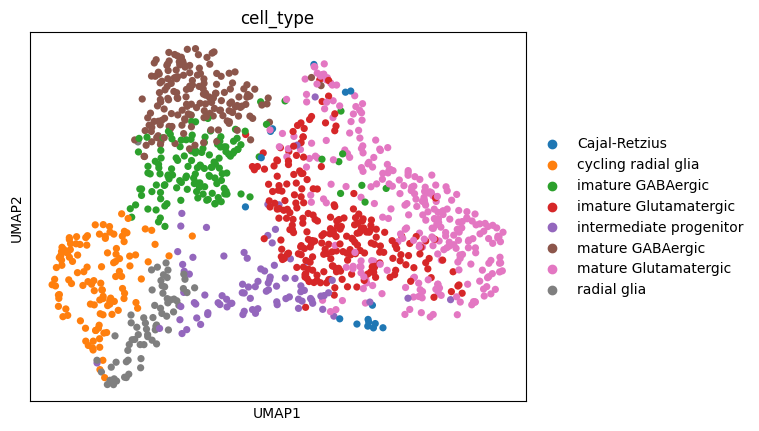

In [13]:
import allos.visuals as vs
sc.tl.umap(combined_mouse_data)
sc.pl.umap(combined_mouse_data, color = 'cell_type')

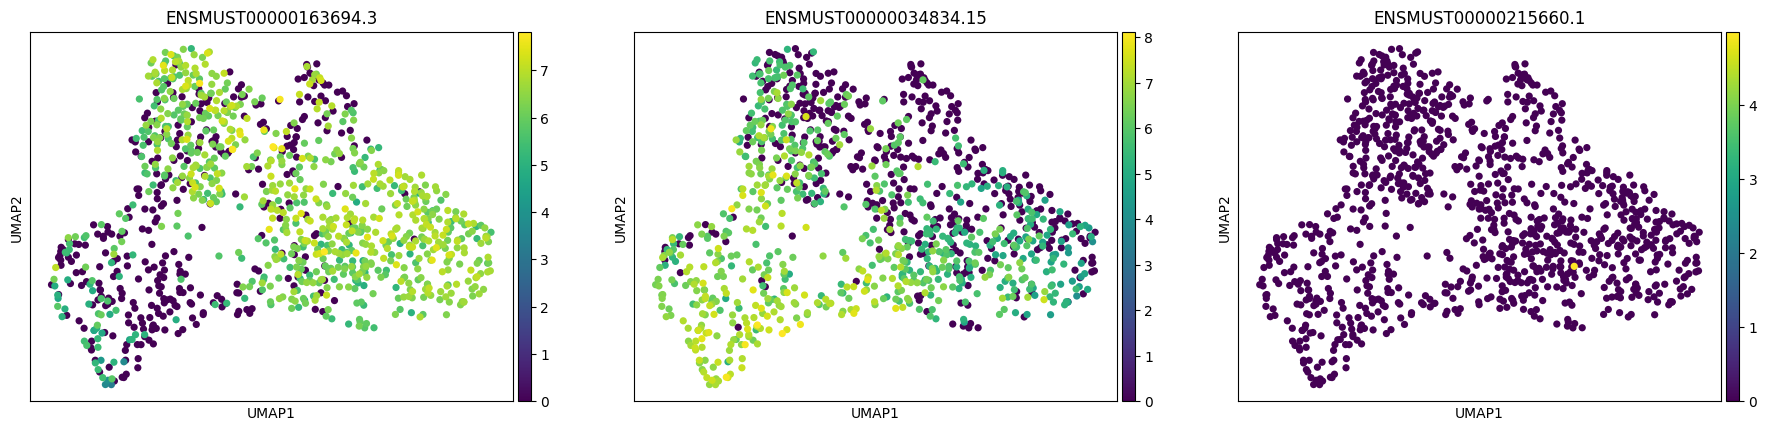

In [14]:
vs.plot_transcripts(combined_mouse_data, gene_id='Pkm')

In [15]:
Pkm_Txs = combined_mouse_data[:, combined_mouse_data.var['geneId'] =='Pkm'].var.index.to_list()

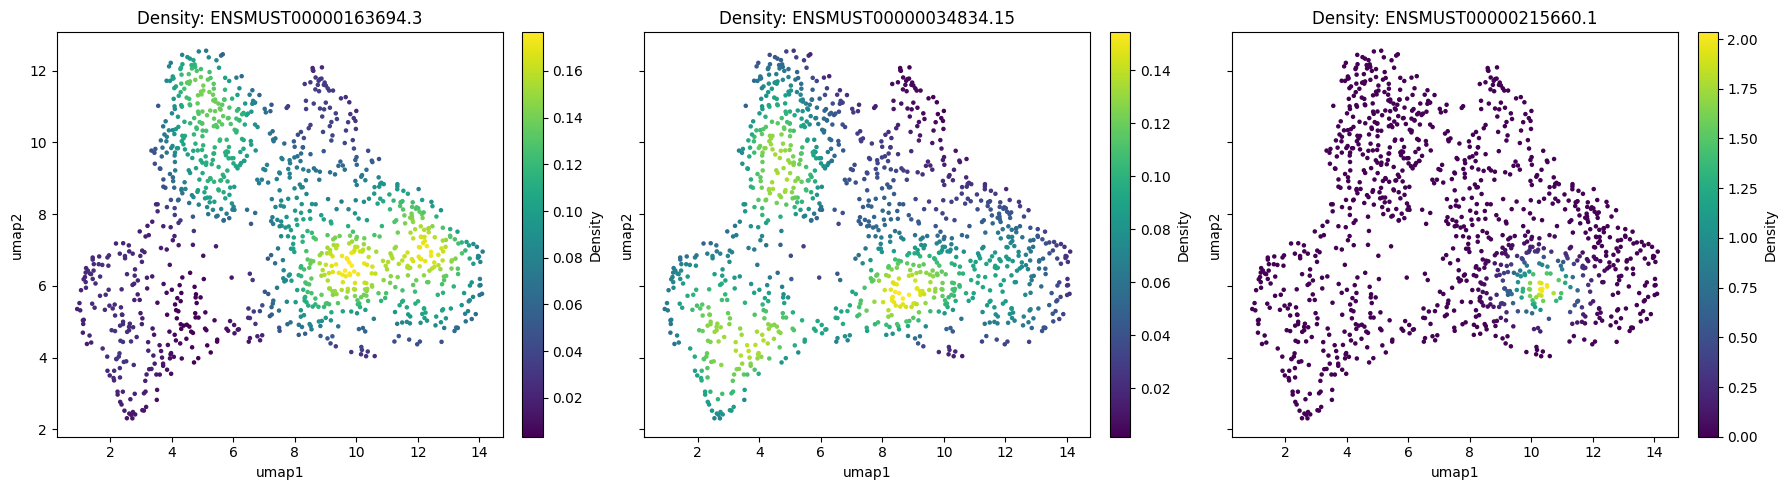

In [21]:
vs.plot_density_multi(combined_mouse_data, features=Pkm_Txs)

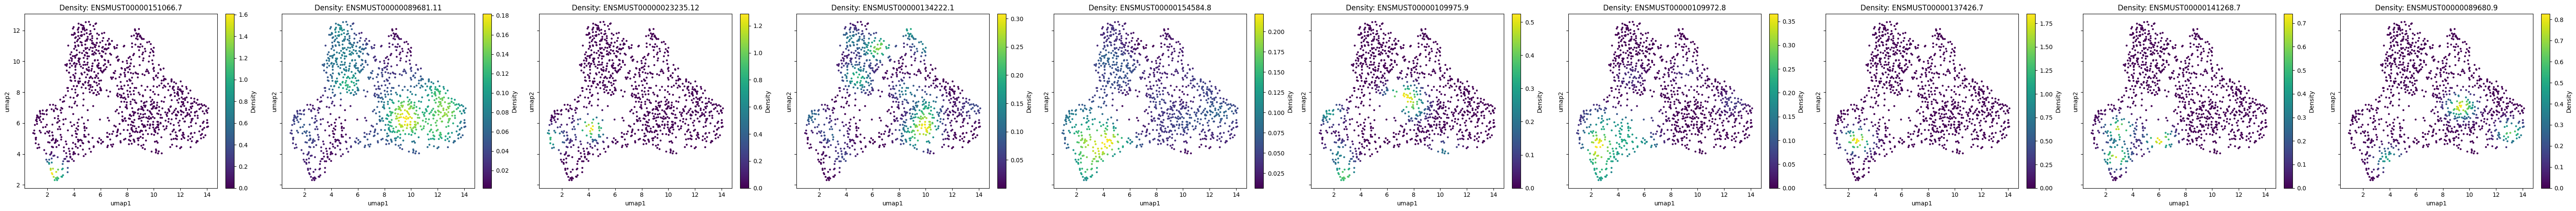

In [23]:
Eef1d_Txs = combined_mouse_data[:, combined_mouse_data.var['geneId'] =='Eef1d'].var.index.to_list()
vs.plot_density_multi(combined_mouse_data, features=Eef1d_Txs)

In [17]:
#| hide
from nbdev.showdoc import *

In [18]:
#| hide
import nbdev; nbdev.nbdev_export()